# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random, models

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 4 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [ ]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)


In [ ]:
# Copy data onto drive s.t. dont need to download every time
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Pfade
drive_path = Path("/content/drive/MyDrive/Galaxy10_DECals_64.h5")
local_path = Path("./Galaxy10_DECals_64.h5")

#!cp "./Galaxy10_DECals_64.h5" "/content/drive/MyDrive/Galaxy10_DECals_64.h5"

# 1. case: data not on google drive
if not drive_path.exists():
    print("start download from cern...")
    !wget -O "{drive_path}" https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
    print("finished download from cern!")
else:
    print("dataset already on google drive")

# 2. case: data on google drive
if not local_path.exists():
    print("copy data from google drive into colab")
    !cp "{drive_path}" "{local_path}"
else:
    print("data already in colab")

# Endgültiger Pfad für den Rest deines Codes
data_path = "./Galaxy10_DECals_64.h5"
print(f"Data path: {data_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset already on google drive
data already in colab
Data path: ./Galaxy10_DECals_64.h5


In [ ]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [ ]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


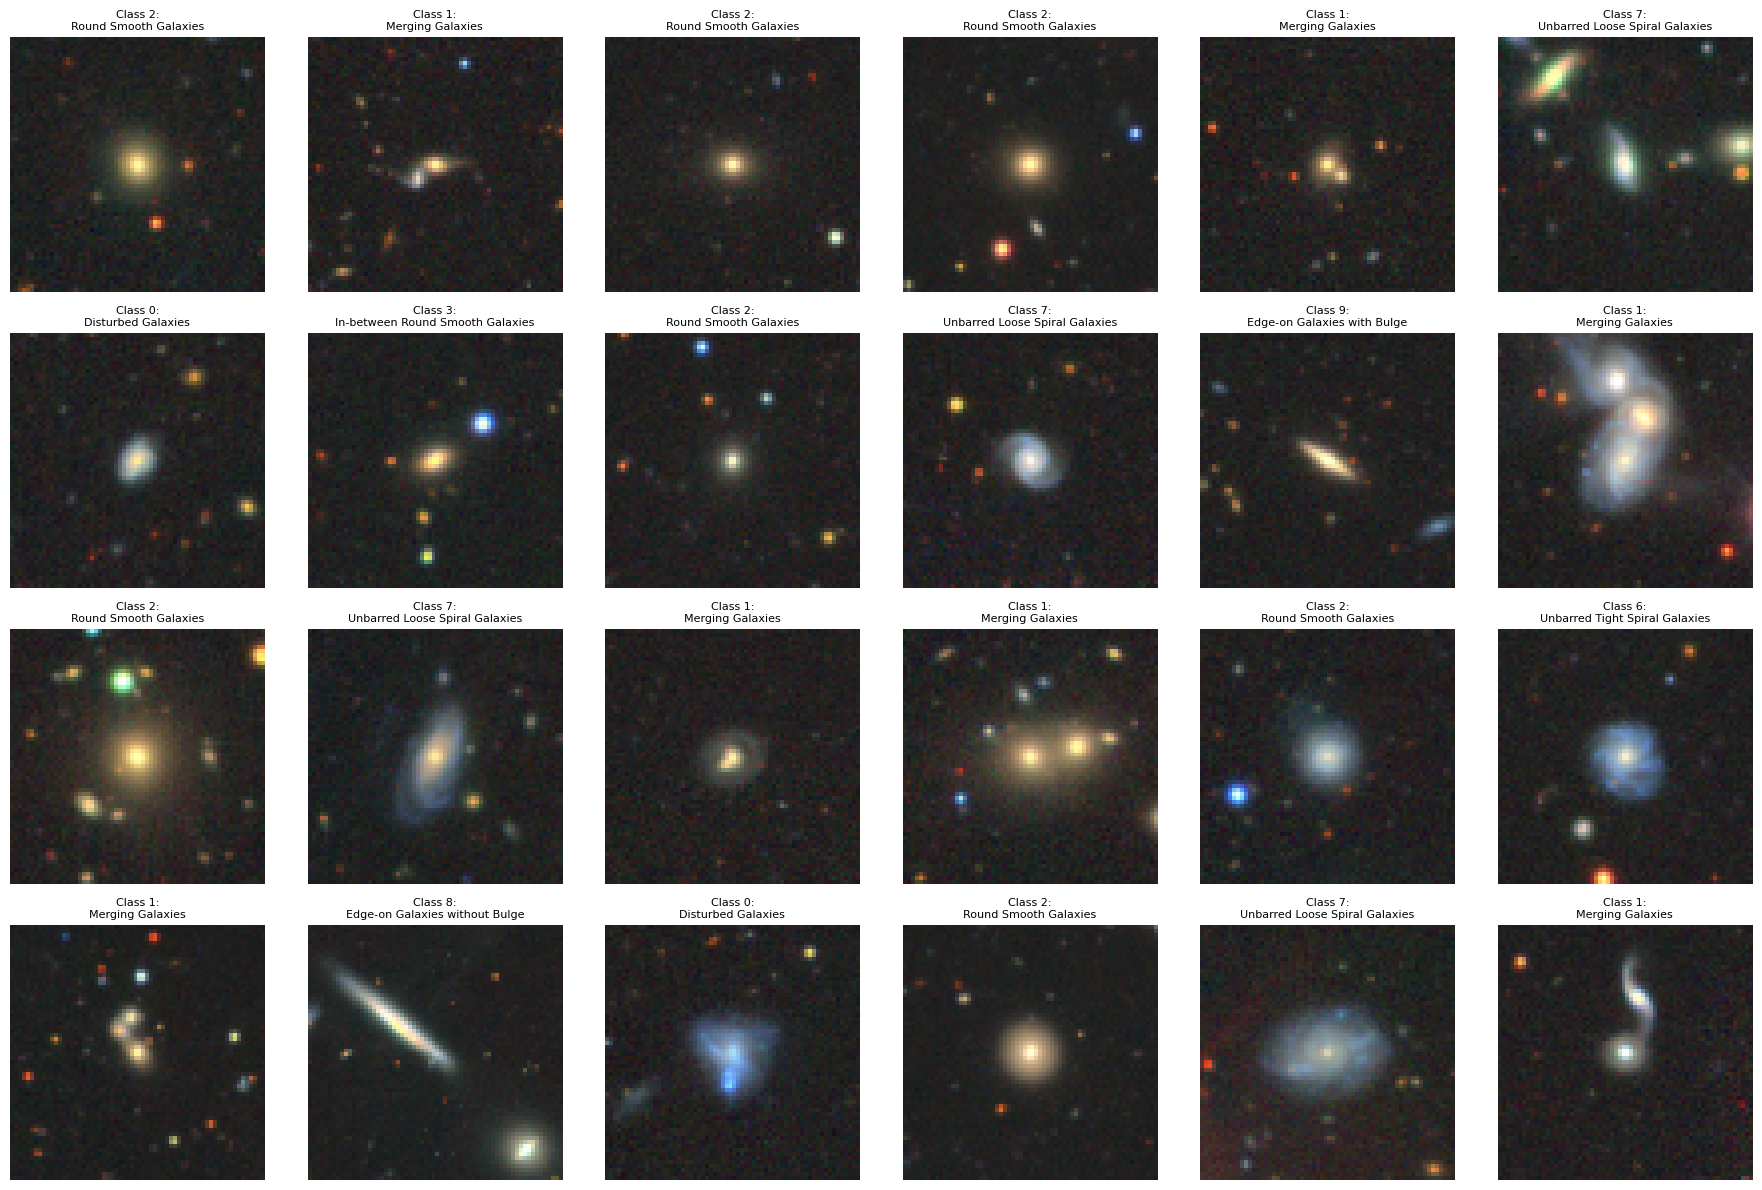

In [ ]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=4, n_cols=6):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [ ]:
# Create anomaly dataset: all class 0 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (16655, 64, 64, 3)
Anomaly images: (1081, 64, 64, 3)


In [ ]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [ ]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8327, 64, 64, 3) (8327,)
Val standard:   (4164, 64, 64, 3) (4164,)
Test standard:  (4164, 64, 64, 3) (4164,)


## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve

In [ ]:
# CAE model for standard dataset
cae_input = keras.Input((64, 64, 3))

# encoder
# first layer 64x64 --> 32x32
x = layers.Conv2D(32, (3, 3), padding="same")(cae_input)
#x = layers.BatchNormalization()    # Removed because of lower AUC, could be because Batchnorm reduces variance of ind. feat.
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)    # get some "stronger edges" (especially for small spiral structure)
                                      # get rid of noice
# second layer 32x32 --> 16x16
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

# third layer 16x16 --> 8x8
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

# bootleneck dim=2048
x = layers.Flatten()(x)
x = layers.Dense(8*8*32)(x)   # reduction dim from 12288 -> 2048 (less leads to too much info loss, more to to flexible model)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
#x = layers.Dropout(0.25)(x)    # Too much information loss
x = layers.Reshape((8, 8, 32))(x)

# decoder
# first layer 8x8 --> 16x16
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.Conv2DTranspose(63, (3, 3), strides=2, padding="same")(x)    # reconstruct more learnabel information than just upsampling

# second layer 16x16 --> 32x32
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)

# third layer 32x32 --> 64x64
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
cae_output = layers.Conv2D(3, (3, 3), padding="same", activation="sigmoid")(x)    # Sigmoid to normalize pixles to [0, 1] again

# compile the model
cae_model = keras.Model(cae_input, cae_output, name="cae")
cae_model.compile(optimizer="adam", loss="mse")

# model summary
print(cae_model.summary())

Model: "cae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_152 (Activation)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_153 (Activation)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_154 (Activation)     │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_155 (Activation)     │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_25 (Reshape)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_156 (Activation)     │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 16, 16, 63)     │        36,351 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 16, 16, 32)     │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_157 (Activation)     │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_158 (Activation)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,556,802 (32.64 MB)

 Trainable params: 8,552,706 (32.63 MB)

 Non-trainable params: 4,096 (16.00 KB)

None


In [ ]:
# Training enhancements
callbacks_ae = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    )]

# Train model
cae_fit = cae_model.fit(
    X_train_std,
    X_train_std,
    epochs=20,
    batch_size=128,
    validation_data=(X_val_std, X_val_std),
    callbacks=callbacks_ae
    )

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - loss: 0.0473 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0070 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0039 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0028 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0025 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0023 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0021 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0022 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0022 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 10/20
66/66

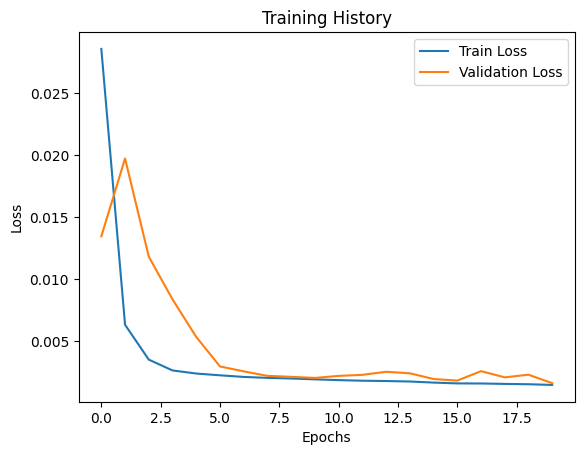

In [ ]:
# plot training history
plt.plot(cae_fit.history['loss'], label='Train Loss')
plt.plot(cae_fit.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# reconstruct some images
X_out_test = cae_model.predict(X_test_std)
X_out_anom = cae_model.predict(anom_images)

# calculate MSE per image
mse_test = np.mean(np.square(X_test_std - X_out_test), axis=(1, 2, 3))
mse_anom = np.mean(np.square(anom_images - X_out_anom), axis=(1, 2, 3))

print(f"\nReconstruction loss (MSE) test set: {mse_test}")
print(f"\nReconstruction loss (MSE) anomaly set: {mse_anom}")

print(f"\nStandard Test Set:")
print(f"  Mean MSE: {mse_test.mean():.6f}")
print(f"  Std MSE:  {mse_test.std():.6f}")
print(f"  Min/Max:  {mse_test.min():.6f} / {mse_test.max():.6f}")
print(f"\nAnomaly Set (Class 0 - Disturbed Galaxies):")
print(f"  Mean MSE: {mse_anom.mean():.6f}")
print(f"  Std MSE:  {mse_anom.std():.6f}")
print(f"  Min/Max:  {mse_anom.min():.6f} / {mse_anom.max():.6f}")
print(f"\nMean Difference: {mse_test.mean() - mse_anom.mean():.6f}")


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Reconstruction loss (MSE) test set: [0.0015717  0.00149352 0.00049248 ... 0.0019217  0.00195174 0.00190049]

Reconstruction loss (MSE) anomaly set: [0.00223971 0.00163877 0.00083783 ... 0.00108491 0.00300548 0.00175511]

Standard Test Set:
  Mean MSE: 0.001857
  Std MSE:  0.000858
  Min/Max:  0.000175 / 0.026561

Anomaly Set (Class 0 - Disturbed Galaxies):
  Mean MSE: 0.001842
  Std MSE:  0.000955
  Min/Max:  0.000610 / 0.022973

Mean Difference: 0.000015


In [ ]:
# difference of mean to small --> model generalizes to well
#                             --> small important features not learned (MSE, Bottleneck, Averaged)

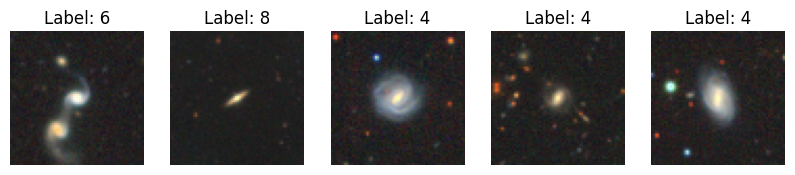

In [ ]:
# Visualize data set galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_test_std[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

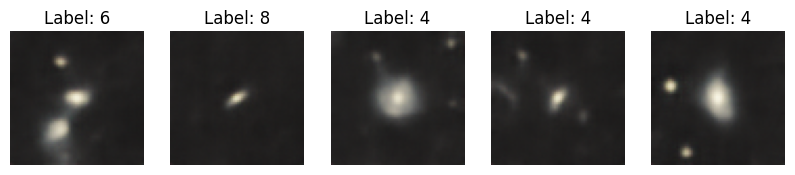

In [ ]:
# Visualize reconstructed galaxies
# (Reconstructed galaxies give a light intensity map)
# (plotted to see connection of AUC, MSE and Recon)
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_out_test[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

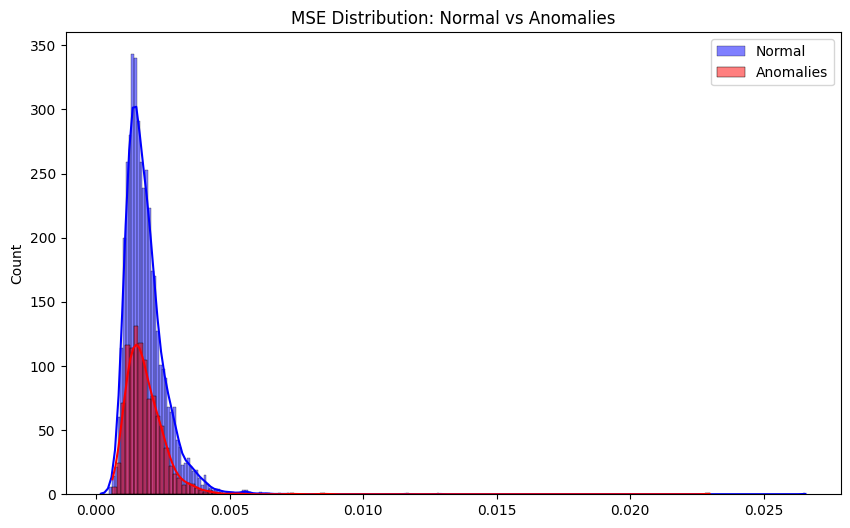

In [ ]:
import seaborn as sns

# Plot the distribution of MSE for normal vs anomalies
plt.figure(figsize=(10,6))
sns.histplot(mse_test, label='Normal', color='blue', kde=True)
sns.histplot(mse_anom, label='Anomalies', color='red', kde=True)
plt.title('MSE Distribution: Normal vs Anomalies')
plt.legend()
plt.show()

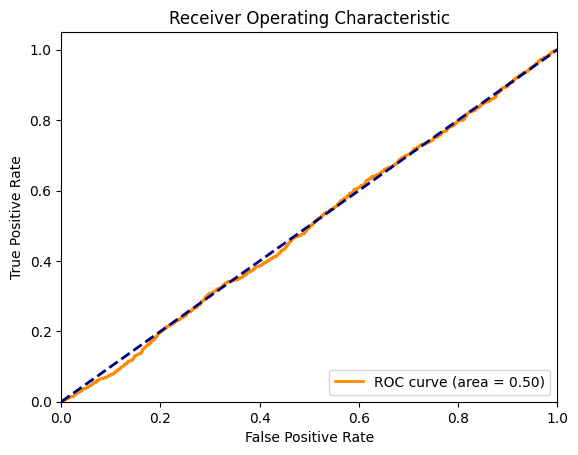

In [ ]:
# ROC curve
# combine normal and anomaly dataset
mse_all = np.concatenate([mse_test, mse_anom])
y_all = np.concatenate([np.zeros(len(mse_test)), np.ones(len(mse_anom))])

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_all, mse_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# If the reconstruction is too good, it generalizes to good and reconstructs even anomalie class (huge variety of galaxies in normal set) --> less than random
# If reconstruction looses information (like here only learning light intensity) it is random
# Reasons:
# 1. AE reconstruction through bootleneck leads to blury recon --> hard to distinguish normal and anomaly, small important features gone
# 2. Balance between recon and feature extraction small
# 3. MSE leads to symmetric penalty --> wrong direction of reconstruction (blurry and averaging)